In [3]:
import json
import re
import torch
from datasets import Dataset
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    DataCollatorForSeq2Seq,
    TrainingArguments,
    Trainer,
)
from peft import LoraConfig, get_peft_model

print("transformers version:", __import__("transformers").__version__)
print("peft version:", __import__("peft").__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# 1) load data from jsonl
data_path = "csqa_full_clean_v2.jsonl"

rows = []
with open(data_path, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        rows.append(json.loads(line))

print("Loaded examples:", len(rows))
print("Example raw row:", rows[0])


def clean_explanation(text: str) -> str:
    if text is None:
        return ""
    text = str(text)
    text = text.replace("```", "").replace("`", "")
    text = re.sub(
        r"\bplaintext\b|\bpython\b|\bjson\b|\btext\b",
        "",
        text,
        flags=re.IGNORECASE,
    )
    text = text.replace("\n", " ").replace("\r", " ")
    text = re.sub(r"\s+", " ", text).strip()
    text = re.sub(r"^(Because\s+)+", "Because ", text, flags=re.IGNORECASE)
    if text and not text.endswith("."):
        text += "."
    return text.strip()


def format_choices(choice_list):
    letters = ["A", "B", "C", "D", "E", "F"]
    return "; ".join(
        f"{letters[i]}: {choice_list[i]}" for i in range(len(choice_list))
    )


processed = []
for ex in rows:
    q = ex["question"]
    choices = ex["choices"]
    ans = ex["answer"]              # "A" / "B" / ...
    expl = clean_explanation(ex.get("short_explanation", ""))

    input_text = (
        f"question: {q}\n"
        f"choices: {format_choices(choices)}\n"
        f"explain your answer:"
    )
    target_text = f"answer: {ans}. {expl}"

    processed.append(
        {
            "input_text": input_text,
            "target_text": target_text,
        }
    )

print("Processed examples:", len(processed))
print(processed[0]["input_text"])
print(processed[0]["target_text"])


transformers version: 4.57.3
peft version: 0.18.0
device: cuda
Loaded examples: 9741
Example raw row: {'question': 'The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?', 'choices': ['ignore', 'enforce', 'authoritarian', 'yell at', 'avoid'], 'answer': 'A', 'short_explanation': 'Because "ignore" best shows the sanctions disregarded the school\'s efforts to change.'}
Processed examples: 9741
question: The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?
choices: A: ignore; B: enforce; C: authoritarian; D: yell at; E: avoid
explain your answer:
answer: A. Because "ignore" best shows the sanctions disregarded the school's efforts to change.


In [5]:
from datasets import Dataset

dataset = Dataset.from_list(processed)
total_size = len(dataset)
train_size = int(0.8 * total_size)

train_dataset = dataset.select(range(train_size))
val_dataset = dataset.select(range(train_size, total_size))
print("total:", total_size, "train:", len(train_dataset), "val:", len(val_dataset))


total: 9741 train: 7792 val: 1949


In [7]:
from transformers import T5Tokenizer

model_name = "google/flan-t5-base"   # CHANGED: use FLAN-T5-base
tokenizer = T5Tokenizer.from_pretrained(model_name)

max_input_length = 384
max_target_length = 96


def basic_clean(t: str) -> str:
    if t is None:
        return ""
    t = str(t)
    t = t.replace("\n", " ").replace("\r", " ")
    t = re.sub(r"\s+", " ", t)
    return t.strip()


def tokenize_function(example):
    input_text = basic_clean(example["input_text"])
    target_text = basic_clean(example["target_text"])

    model_inputs = tokenizer(
        input_text,
        max_length=max_input_length,
        truncation=True,
        padding="max_length",
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            target_text,
            max_length=max_target_length,
            truncation=True,
            padding="max_length",
        )["input_ids"]

    model_inputs["labels"] = labels
    return model_inputs


train_tokenized = train_dataset.map(
    tokenize_function,
    batched=False,
    remove_columns=train_dataset.column_names,
)
val_tokenized = val_dataset.map(
    tokenize_function,
    batched=False,
    remove_columns=val_dataset.column_names,
)

cols = ["input_ids", "attention_mask", "labels"]
train_tokenized.set_format(type="torch", columns=cols)
val_tokenized.set_format(type="torch", columns=cols)

print(len(train_tokenized), len(val_tokenized))


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Map:   0%|          | 0/7792 [00:00<?, ? examples/s]

D:\py\Lib\site-packages\transformers\tokenization_utils_base.py:4169: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/1949 [00:00<?, ? examples/s]

7792 1949


In [9]:
from transformers import T5ForConditionalGeneration
from peft import LoraConfig, get_peft_model

base_model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q", "v"],
    task_type="SEQ_2_SEQ_LM",   # keep exactly as in your old code
)

model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()


trainable params: 1,769,472 || all params: 249,347,328 || trainable%: 0.7096


In [11]:
from transformers import DataCollatorForSeq2Seq, TrainingArguments, Trainer

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

training_args = TrainingArguments(
    output_dir="./flan_t5_base_csqa_lora_v2",  # new name to avoid overwrite
    overwrite_output_dir=True,

    num_train_epochs=3,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=16,

    learning_rate=5e-5,        # CHANGED: smaller LR than 2e-4
    warmup_ratio=0.1,
    logging_steps=50,

    save_steps=1000,
    save_total_limit=2,

    do_train=True,
    do_eval=True,

    fp16=False,                # keep fp16 off, same as old code
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    data_collator=data_collator,
    tokenizer=tokenizer,
)


C:\Users\yanch\AppData\Local\Temp\ipykernel_61640\4230611125.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [13]:
train_result = trainer.train()
print(train_result)


D:\py\Lib\site-packages\transformers\data\data_collator.py:740: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)


Step,Training Loss
50,40.936400
100,37.648700
150,28.812500
200,16.110500
250,5.814700
300,4.494800
350,4.159600
400,3.693400
450,3.029000
500,2.477900


TrainOutput(global_step=1461, training_loss=5.766903509757521, metrics={'train_runtime': 4471.7021, 'train_samples_per_second': 5.228, 'train_steps_per_second': 0.327, 'total_flos': 1.2100466664013824e+16, 'train_loss': 5.766903509757521, 'epoch': 3.0})


In [24]:
import re
import json
import random
import os
import torch
import pandas as pd

model.eval()  # eval mode


def extract_answer(pred_text: str):
    """
    Extract choice letter (A-F) from model prediction.
    Looks for patterns like 'answer: B', 'answer B.', etc.
    """
    text = pred_text.strip().lower()
    m = re.search(r"answer[: ]*\s*([a-f])", text)
    if m:
        return m.group(1).upper()
    return None


# =========================
# 1) Sample up to 200 examples from validation set
# =========================

val_size = len(val_dataset)
n_eval = min(200, val_size)

indices = list(range(val_size))
random.seed(42)  # for reproducibility
sample_indices = random.sample(indices, n_eval)

# local indices in val_dataset -> global indices in rows
# val_dataset 是 dataset[train_size:] 那一段
global_indices = [train_size + i for i in sample_indices]

subset = val_dataset.select(sample_indices)
subset_list = list(subset)

print(f"Using {n_eval} validation examples (sampled from {val_size})")


# =========================
# 2) Run model, compute accuracy, collect predictions
# =========================

results = []  # will store dicts
correct = 0

with torch.no_grad():
    for ex, g_idx in zip(subset_list, global_indices):
        # correct answer comes from original rows
        gold_answer = rows[g_idx]["answer"]  # "A", "B", ...

        inputs = tokenizer(
            ex["input_text"],
            return_tensors="pt",
            max_length=max_input_length,
            truncation=True,
        )
        gen_ids = model.generate(
            input_ids=inputs["input_ids"].to(device),
            max_length=max_target_length,
            num_beams=4,
        )
        pred_text = tokenizer.decode(gen_ids[0], skip_special_tokens=True)
        pred_ans = extract_answer(pred_text)

        is_correct = (pred_ans == gold_answer)

        if is_correct:
            correct += 1

        results.append(
            {
                "input_text": ex["input_text"],
                "target_text": ex["target_text"],
                "correct_answer": gold_answer,
                "predicted_answer": pred_ans,
                "prediction_text": pred_text,
                "is_correct": is_correct,
            }
        )

accuracy = correct / n_eval if n_eval > 0 else 0.0
print(f"Validation accuracy on {n_eval} examples: {accuracy:.4f} ({accuracy*100:.2f}%)")


# =========================
# 3) Show first few examples with predictions
# =========================

num_show = 5

for i, rec in enumerate(results[:num_show]):
    print("=" * 80)
    print(f"Validation example {i}")
    print(f"Correct answer: {rec['correct_answer']}")
    print(f"Predicted: {rec['predicted_answer']}")
    print("RIGHT ✓" if rec["is_correct"] else "WRONG ✗")

    print("\nINPUT:")
    print(rec["input_text"])

    print("\nTARGET:")
    print(rec["target_text"])

    print("\nPREDICTION:")
    print(rec["prediction_text"])
    print()


# =========================
# 4) Save these 200 (or fewer) results to CSV and JSONL
# =========================

try:
    out_dir = trainer.args.output_dir
except NameError:
    out_dir = "./flan_t5_base_csqa_lora_v2"

os.makedirs(out_dir, exist_ok=True)

csv_path = os.path.join(out_dir, "validation_sample_outputs.csv")
jsonl_path = os.path.join(out_dir, "validation_sample_outputs.jsonl")

pd.DataFrame(results).to_csv(csv_path, index=False)
print("Saved CSV to:", csv_path)

with open(jsonl_path, "w", encoding="utf-8") as f:
    for rec in results:
        f.write(json.dumps(rec, ensure_ascii=False) + "\n")
print("Saved JSONL to:", jsonl_path)


Using 200 validation examples (sampled from 1949)
Validation accuracy on 200 examples: 0.6450 (64.50%)
Validation example 0
Correct answer: E
Predicted: E
RIGHT ✓

INPUT:
question: Danny needed a new mouse, his was jumping around whenever he moved it. Where might his mouse be?
choices: A: abandoned houses; B: corn field; C: cupboard; D: cabinet; E: desktop
explain your answer:

TARGET:
answer: E. Because a desktop allows for a mouse's typical use and movement, making E the correct answer.

PREDICTION:
answer: E. Because Danny needed a new mouse.

Validation example 1
Correct answer: A
Predicted: A
RIGHT ✓

INPUT:
question: Who can have the most influence on washington from a given county?
choices: A: representative; B: cleverest; C: bitterest; D: alter; E: sweet
explain your answer:

TARGET:
answer: A. Because representatives have formal channels to influence federal legislation, making A the correct choice.

PREDICTION:
answer: A. Because representative can have the most influence on 

In [48]:
import os
import json
import random
import re
from typing import Dict, Any, List

import torch
import pandas as pd
from datasets import load_dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration
from peft import PeftModel

# ==========================
# 0. Device
# ==========================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# ==========================
# 1. Load CSQA-trained FLAN-T5-base + LoRA (checkpoint-1461)
# ==========================

base_model_name = "google/flan-t5-base"
checkpoint_dir = "./flan_t5_base_csqa_lora_v2/checkpoint-1461"  # adjust if needed

print("Loading base model and LoRA checkpoint...")
tokenizer = T5Tokenizer.from_pretrained(base_model_name)

base_model = T5ForConditionalGeneration.from_pretrained(
    base_model_name
).to(device)

model = PeftModel.from_pretrained(
    base_model,
    checkpoint_dir,
).to(device)

model.eval()
print("Loaded model from", checkpoint_dir)

max_input_length = 384
max_target_length = 96

# ==========================
# 2. Load CoS-E v1.11 from HuggingFace
# ==========================

print("Loading CoS-E v1.11 dataset...")
dataset = load_dataset("Salesforce/cos_e", "v1.11")

train_raw = dataset["train"]
val_raw = dataset["validation"]

print("Example raw sample:")
print(train_raw[0])

# ==========================
# 3. Build multiple-choice formatted dataset
# ==========================

def build_mc(example: Dict[str, Any]) -> Dict[str, Any]:
    choices = example["choices"]
    answer = example["answer"]

    if not isinstance(choices, list) or len(choices) < 3:
        return {"valid": False}
    if answer not in choices:
        return {"valid": False}

    return {
        "id": example["id"],
        "question": example["question"],
        "choices": choices,
        "answer": answer,
        "answer_idx": choices.index(answer),
        "abstractive_explanation": example["abstractive_explanation"],
        "extractive_explanation": example["extractive_explanation"],
        "valid": True,
    }

print("Building MC version...")
train_mc = train_raw.map(build_mc)
val_mc = val_raw.map(build_mc)

train_mc = train_mc.filter(lambda x: x["valid"])
val_mc = val_mc.filter(lambda x: x["valid"])

print("Example MC sample:")
print(train_mc[0])

# ==========================
# 4. Helper to extract answer letter from model output
# ==========================

def extract_answer(pred_text: str) -> str:
    """
    Extract choice letter (A-F) from model prediction.
    Looks for patterns like 'answer: B', 'answer B.', etc.
    """
    text = pred_text.strip().lower()
    m = re.search(r"answer[: ]*\s*([a-f])", text)
    if m:
        return m.group(1).upper()
    return None

# ==========================
# 5. Sample up to 200 examples from CoS-E validation MC
# ==========================

val_size = len(val_mc)
n_eval = min(200, val_size)

print(f"Validation MC size: {val_size}, evaluating on {n_eval} examples")

val_mc_shuffled = val_mc.shuffle(seed=42)
subset = val_mc_shuffled.select(range(n_eval))

# ==========================
# 6. Run evaluation
# ==========================

letters = ["A", "B", "C", "D", "E", "F"]
correct = 0
results: List[Dict[str, Any]] = []

with torch.no_grad():
    for ex in subset:
        question = ex["question"]
        choices = ex["choices"]              # list of strings
        answer_idx = ex["answer_idx"]        # correct index
        gold_letter = letters[answer_idx]    # "A"/"B"/...

        formatted_choices = "; ".join(
            f"{letters[i]}: {choices[i]}" for i in range(len(choices))
        )

        input_text = (
            f"question: {question}\n"
            f"choices: {formatted_choices}\n"
            f"explain your answer:"
        )

        inputs = tokenizer(
            input_text,
            return_tensors="pt",
            max_length=max_input_length,
            truncation=True,
        )

        gen_ids = model.generate(
            input_ids=inputs["input_ids"].to(device),
            max_length=max_target_length,
            num_beams=4,
        )

        pred_text = tokenizer.decode(gen_ids[0], skip_special_tokens=True)
        pred_letter = extract_answer(pred_text)

        is_correct = (pred_letter == gold_letter)
        if is_correct:
            correct += 1

        results.append(
            {
                "id": ex["id"],
                "question": question,
                "choices": choices,
                "correct_letter": gold_letter,
                "correct_answer_text": ex["answer"],
                "predicted_letter": pred_letter,
                "prediction_text": pred_text,
                "is_correct": is_correct,
            }
        )

accuracy = correct / n_eval if n_eval > 0 else 0.0
print(f"\nCoS-E v1.11 validation accuracy on {n_eval} examples: {accuracy:.4f} ({accuracy*100:.2f}%)")

# ==========================
# 7. Show first few examples
# ==========================

num_show = 5
for i, rec in enumerate(results[:num_show]):
    print("=" * 80)
    print(f"CoS-E example {i}")
    print(f"Correct letter: {rec['correct_letter']}")
    print(f"Predicted letter: {rec['predicted_letter']}")
    print("RIGHT ✓" if rec["is_correct"] else "WRONG ✗")

    print("\nQUESTION:")
    print(rec["question"])

    print("\nCHOICES:")
    for idx, text in enumerate(rec["choices"]):
        print(f"  {letters[idx]}: {text}")

    print("\nPREDICTION TEXT:")
    print(rec["prediction_text"])
    print()

# ==========================
# 8. Save results (optional)
# ==========================

out_dir = "./flan_t5_base_csqa_lora_v2"
os.makedirs(out_dir, exist_ok=True)

csv_path = os.path.join(out_dir, "cose_v1_11_val_sample_outputs.csv")
jsonl_path = os.path.join(out_dir, "cose_v1_11_val_sample_outputs.jsonl")

pd.DataFrame(results).to_csv(csv_path, index=False)
print("Saved CSV to:", csv_path)

with open(jsonl_path, "w", encoding="utf-8") as f:
    for rec in results:
        f.write(json.dumps(rec, ensure_ascii=False) + "\n")
print("Saved JSONL to:", jsonl_path)


device: cuda
Loading base model and LoRA checkpoint...
Loaded model from ./flan_t5_base_csqa_lora_v2/checkpoint-1461
Loading CoS-E v1.11 dataset...
Example raw sample:
{'id': '6b819727eb8a670df26a7ffad036c119', 'question': '"There are 10 apples on an apple tree.  Three fall off.  Now there are X apples."  What is this an example of?', 'choices': ['park', 'coloring book', 'garden center', 'math problem', 'gravity'], 'answer': 'math problem', 'abstractive_explanation': 'webmath is designed to help you solve', 'extractive_explanation': '"there are 10 apples on an apple tree. three fall off. now there are x apples." what is this an example of?'}
Building MC version...


Map:   0%|          | 0/9741 [00:00<?, ? examples/s]

Map:   0%|          | 0/1221 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9741 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1221 [00:00<?, ? examples/s]

Example MC sample:
{'id': '6b819727eb8a670df26a7ffad036c119', 'question': '"There are 10 apples on an apple tree.  Three fall off.  Now there are X apples."  What is this an example of?', 'choices': ['park', 'coloring book', 'garden center', 'math problem', 'gravity'], 'answer': 'math problem', 'abstractive_explanation': 'webmath is designed to help you solve', 'extractive_explanation': '"there are 10 apples on an apple tree. three fall off. now there are x apples." what is this an example of?', 'answer_idx': 3, 'valid': True}
Validation MC size: 1221, evaluating on 200 examples

CoS-E v1.11 validation accuracy on 200 examples: 0.4800 (48.00%)
CoS-E example 0
Correct letter: D
Predicted letter: D
RIGHT ✓

QUESTION:
At a grocery store they sell individual potatoes, where does the grocery clerk likely put the potato?

CHOICES:
  A: boiling water
  B: root cellar
  C: rocket ship
  D: paper bag
  E: underground

PREDICTION TEXT:
answer: D. Because the grocery clerk likely puts the potato 

transformers version: 4.57.3
peft version: 0.18.0
device: cuda
Loaded examples: 9741
Example raw row: {'question': 'The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?', 'choices': ['ignore', 'enforce', 'authoritarian', 'yell at', 'avoid'], 'answer': 'A', 'short_explanation': 'Because "ignore" best shows the sanctions disregarded the school\'s efforts to change.'}
Processed examples: 9741
Example formatted input:
 question: The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?
choices: A: ignore; B: enforce; C: authoritarian; D: yell at; E: avoid
explain your answer:
Example formatted target:
 answer: A. Because "ignore" best shows the sanctions disregarded the school's efforts to change.
total: 9741 train: 7792 val: 1949


Map:   0%|          | 0/7792 [00:00<?, ? examples/s]

D:\py\Lib\site-packages\transformers\tokenization_utils_base.py:4169: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/1949 [00:00<?, ? examples/s]

Tokenized sizes: 7792 1949
trainable params: 4,718,592 || all params: 787,868,672 || trainable%: 0.5989


C:\Users\yanch\AppData\Local\Temp\ipykernel_61640\3384732169.py:212: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,35.450800
100,33.150800
150,27.617400
200,20.899400
250,16.924100
300,15.185900
350,13.411700
400,11.258400
450,9.525800
500,7.478900


TrainOutput(global_step=974, training_loss=12.203589570595744, metrics={'train_runtime': 36907.8475, 'train_samples_per_second': 0.422, 'train_steps_per_second': 0.026, 'total_flos': 2.7107551384436736e+16, 'train_loss': 12.203589570595744, 'epoch': 2.0})
Saved LoRA FLAN-T5-large model to ./flan_t5_large_csqa_lora_v1
Saved training log to ./flan_t5_large_csqa_lora_v1/training_log_large.csv
Saved loss curve figure to ./flan_t5_large_csqa_lora_v1/training_loss_large.png


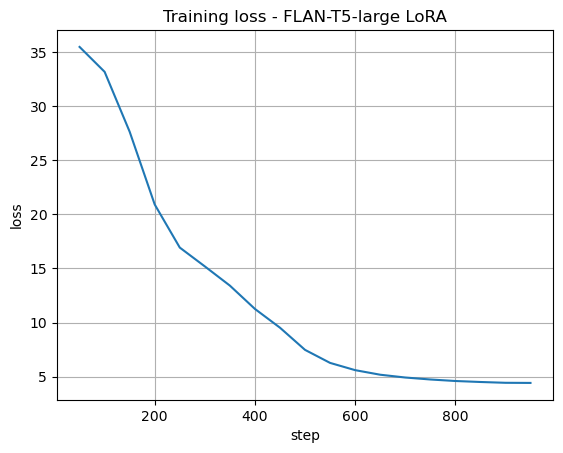

In [50]:
import json
import re
import torch
import pandas as pd
import matplotlib.pyplot as plt

from datasets import Dataset
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    DataCollatorForSeq2Seq,
    TrainingArguments,
    Trainer,
)
from peft import LoraConfig, get_peft_model

print("transformers version:", __import__("transformers").__version__)
print("peft version:", __import__("peft").__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# =========================
# 1. Load data and preprocess
# =========================

data_path = "csqa_full_clean_v2.jsonl"

rows = []
with open(data_path, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        rows.append(json.loads(line))

print("Loaded examples:", len(rows))
print("Example raw row:", rows[0])


def clean_explanation(text: str) -> str:
    if text is None:
        return ""
    text = str(text)
    text = text.replace("```", "").replace("`", "")
    text = re.sub(
        r"\bplaintext\b|\bpython\b|\bjson\b|\btext\b",
        "",
        text,
        flags=re.IGNORECASE,
    )
    text = text.replace("\n", " ").replace("\r", " ")
    text = re.sub(r"\s+", " ", text).strip()
    text = re.sub(r"^(Because\s+)+", "Because ", text, flags=re.IGNORECASE)
    if text and not text.endswith("."):
        text += "."
    return text.strip()


def format_choices(choice_list):
    letters = ["A", "B", "C", "D", "E", "F"]
    return "; ".join(
        f"{letters[i]}: {choice_list[i]}" for i in range(len(choice_list))
    )


processed = []
for ex in rows:
    q = ex["question"]
    choices = ex["choices"]
    ans = ex["answer"]              # "A" / "B" / ...
    expl = clean_explanation(ex.get("short_explanation", ""))

    input_text = (
        f"question: {q}\n"
        f"choices: {format_choices(choices)}\n"
        f"explain your answer:"
    )
    target_text = f"answer: {ans}. {expl}"

    processed.append(
        {
            "input_text": input_text,
            "target_text": target_text,
            "answer": ans,        # keep answer for later eval
        }
    )

print("Processed examples:", len(processed))
print("Example formatted input:\n", processed[0]["input_text"])
print("Example formatted target:\n", processed[0]["target_text"])

# =========================
# 2. Split into train/val (80/20)
# =========================

dataset = Dataset.from_list(processed)
total_size = len(dataset)
train_size = int(0.8 * total_size)

train_dataset = dataset.select(range(train_size))
val_dataset = dataset.select(range(train_size, total_size))

print("total:", total_size, "train:", len(train_dataset), "val:", len(val_dataset))

# =========================
# 3. Tokenizer and tokenization (FLAN-T5-large)
# =========================

model_name = "google/flan-t5-large"
tokenizer = T5Tokenizer.from_pretrained(model_name)

max_input_length = 384
max_target_length = 96


def basic_clean(t: str) -> str:
    if t is None:
        return ""
    t = str(t)
    t = t.replace("\n", " ").replace("\r", " ")
    t = re.sub(r"\s+", " ", t)
    return t.strip()


def tokenize_function(example):
    input_text = basic_clean(example["input_text"])
    target_text = basic_clean(example["target_text"])

    model_inputs = tokenizer(
        input_text,
        max_length=max_input_length,
        truncation=True,
        padding="max_length",
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            target_text,
            max_length=max_target_length,
            truncation=True,
            padding="max_length",
        )["input_ids"]

    model_inputs["labels"] = labels
    return model_inputs


train_tokenized = train_dataset.map(
    tokenize_function,
    batched=False,
    remove_columns=train_dataset.column_names,
)
val_tokenized = val_dataset.map(
    tokenize_function,
    batched=False,
    remove_columns=val_dataset.column_names,
)

cols = ["input_ids", "attention_mask", "labels"]
train_tokenized.set_format(type="torch", columns=cols)
val_tokenized.set_format(type="torch", columns=cols)

print("Tokenized sizes:", len(train_tokenized), len(val_tokenized))

# =========================
# 4. Load FLAN-T5-large + LoRA
# =========================

base_model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q", "v"],
    task_type="SEQ_2_SEQ_LM",   # string style, same as your old code
)

model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()

# =========================
# 5. TrainingArguments (smaller LR, fewer epochs) + Trainer
# =========================

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

training_args = TrainingArguments(
    output_dir="./flan_t5_large_csqa_lora_v1",
    overwrite_output_dir=True,

    num_train_epochs=2,                 # shorter than 3
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=16,

    learning_rate=3e-5,                 # smaller LR for large model
    warmup_ratio=0.1,
    logging_steps=50,

    save_steps=1000,
    save_total_limit=2,

    do_train=True,
    do_eval=True,

    fp16=False,                         # full precision for stability
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

train_result = trainer.train()
print(train_result)

# =========================
# 6. Save model, tokenizer, and training logs
# =========================

save_dir = "./flan_t5_large_csqa_lora_v1"

trainer.model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print("Saved LoRA FLAN-T5-large model to", save_dir)

# ---- save raw training log ----
log_history = trainer.state.log_history
log_df = pd.DataFrame(log_history)
log_csv_path = f"{save_dir}/training_log_large.csv"
log_df.to_csv(log_csv_path, index=False)
print("Saved training log to", log_csv_path)

# ---- plot training loss curve ----
loss_df = log_df[log_df["loss"].notna()] if "loss" in log_df.columns else pd.DataFrame()

if not loss_df.empty:
    plt.figure()
    plt.plot(loss_df["step"], loss_df["loss"])
    plt.xlabel("step")
    plt.ylabel("loss")
    plt.title("Training loss - FLAN-T5-large LoRA")
    plt.grid(True)
    loss_fig_path = f"{save_dir}/training_loss_large.png"
    plt.savefig(loss_fig_path, bbox_inches="tight")
    print("Saved loss curve figure to", loss_fig_path)
else:
    print("No loss data found in log history.")


In [54]:
import re
import json
import random
import os
import torch
import pandas as pd

# Make sure this is your FLAN-T5-large LoRA model
model.eval()  # eval mode


def extract_answer(pred_text: str):
    """
    Extract choice letter (A-F) from model prediction.
    Looks for patterns like 'answer: B', 'answer B.', etc.
    """
    text = pred_text.strip().lower()
    m = re.search(r"answer[: ]*\s*([a-f])", text)
    if m:
        return m.group(1).upper()
    return None


# =========================
# 1) Sample up to 200 examples from validation set
# =========================

val_size = len(val_dataset)
n_eval = min(200, val_size)

indices = list(range(val_size))
random.seed(42)  # reproducibility
sample_indices = random.sample(indices, n_eval)

# local indices in val_dataset -> global indices in rows
# val_dataset is dataset[train_size:] part
global_indices = [train_size + i for i in sample_indices]

subset = val_dataset.select(sample_indices)
subset_list = list(subset)

print(f"Using {n_eval} validation examples (sampled from {val_size})")


# =========================
# 2) Run model, compute accuracy, collect predictions
# =========================

results = []  # list of dicts
correct = 0

with torch.no_grad():
    for ex, g_idx in zip(subset_list, global_indices):
        # gold answer comes from original rows
        gold_answer = rows[g_idx]["answer"]  # "A", "B", ...

        inputs = tokenizer(
            ex["input_text"],
            return_tensors="pt",
            max_length=max_input_length,
            truncation=True,
        )

        gen_ids = model.generate(
            input_ids=inputs["input_ids"].to(device),
            max_length=max_target_length,
            num_beams=4,
        )

        pred_text = tokenizer.decode(gen_ids[0], skip_special_tokens=True)
        pred_ans = extract_answer(pred_text)

        is_correct = (pred_ans == gold_answer)
        if is_correct:
            correct += 1

        results.append(
            {
                "input_text": ex["input_text"],
                "target_text": ex["target_text"],
                "correct_answer": gold_answer,
                "predicted_answer": pred_ans,
                "prediction_text": pred_text,
                "is_correct": is_correct,
            }
        )

accuracy = correct / n_eval if n_eval > 0 else 0.0
print(f"Validation accuracy on {n_eval} examples: {accuracy:.4f} ({accuracy*100:.2f}%)")


# =========================
# 3) Show first few examples with predictions
# =========================

num_show = 5

for i, rec in enumerate(results[:num_show]):
    print("=" * 80)
    print(f"Validation example {i}")
    print(f"Correct answer: {rec['correct_answer']}")
    print(f"Predicted: {rec['predicted_answer']}")
    print("RIGHT ✓" if rec["is_correct"] else "WRONG ✗")

    print("\nINPUT:")
    print(rec["input_text"])

    print("\nTARGET:")
    print(rec["target_text"])

    print("\nPREDICTION:")
    print(rec["prediction_text"])
    print()


# =========================
# 4) Save these 200 (or fewer) results to CSV and JSONL
# =========================

try:
    out_dir = trainer.args.output_dir
except NameError:
    # change this to your FLAN-T5-large output dir if different
    out_dir = "./flan_t5_large_csqa_lora_v1"

os.makedirs(out_dir, exist_ok=True)

csv_path = os.path.join(out_dir, "validation_sample_outputs_large.csv")
jsonl_path = os.path.join(out_dir, "validation_sample_outputs_large.jsonl")

pd.DataFrame(results).to_csv(csv_path, index=False)
print("Saved CSV to:", csv_path)

with open(jsonl_path, "w", encoding="utf-8") as f:
    for rec in results:
        f.write(json.dumps(rec, ensure_ascii=False) + "\n")
print("Saved JSONL to:", jsonl_path)


Using 200 validation examples (sampled from 1949)
Validation accuracy on 200 examples: 0.3750 (37.50%)
Validation example 0
Correct answer: E
Predicted: None
WRONG ✗

INPUT:
question: Danny needed a new mouse, his was jumping around whenever he moved it. Where might his mouse be?
choices: A: abandoned houses; B: corn field; C: cupboard; D: cabinet; E: desktop
explain your answer:

TARGET:
answer: E. Because a desktop allows for a mouse's typical use and movement, making E the correct answer.

PREDICTION:
When a mouse jumps around, it needs a new one. The answer is E.

Validation example 1
Correct answer: A
Predicted: A
RIGHT ✓

INPUT:
question: Who can have the most influence on washington from a given county?
choices: A: representative; B: cleverest; C: bitterest; D: alter; E: sweet
explain your answer:

TARGET:
answer: A. Because representatives have formal channels to influence federal legislation, making A the correct choice.

PREDICTION:
Having the most influence on Washington fro

In [58]:
import re
import json
import random
import os
import torch
import pandas as pd

# Make sure this is your FLAN-T5-large LoRA model
model.eval()  # eval mode


def extract_answer_letter(pred_text: str):
    """
    Try to extract choice letter (A-F) from model prediction.
    Handles patterns like:
      - answer: B
      - answer B
      - answer is B
      - the answer is B
      - the answer: B
    """
    text = pred_text.strip().lower()

    # main pattern: optional "the", then "answer", then (is | : | space), then letter
    m = re.search(
        r"(?:the\s+)?answer(?:\s+is|[: ]+)\s*([a-f])",
        text,
    )
    if m:
        return m.group(1).upper()

    # fallback: old very simple pattern, just in case
    m2 = re.search(r"answer[: ]*\s*([a-f])", text)
    if m2:
        return m2.group(1).upper()

    return None


# =========================
# 1) Sample up to 200 examples from validation set
# =========================

val_size = len(val_dataset)
n_eval = min(200, val_size)

indices = list(range(val_size))
random.seed(42)  # reproducibility
sample_indices = random.sample(indices, n_eval)

# local indices in val_dataset -> global indices in rows
# val_dataset is dataset[train_size:] part
global_indices = [train_size + i for i in sample_indices]

subset = val_dataset.select(sample_indices)
subset_list = list(subset)

print(f"Using {n_eval} validation examples (sampled from {val_size})")


# =========================
# 2) Run model, compute accuracy (lenient), collect predictions
# =========================

results = []  # list of dicts
correct = 0
letters = ["A", "B", "C", "D", "E", "F"]

with torch.no_grad():
    for ex, g_idx in zip(subset_list, global_indices):
        raw = rows[g_idx]
        gold_answer = raw["answer"]         # "A", "B", ...
        choices = raw["choices"]            # list of choice texts

        # gold choice text (what the option actually says)
        gold_idx = letters.index(gold_answer)
        gold_text = str(choices[gold_idx]).strip().lower()

        inputs = tokenizer(
            ex["input_text"],
            return_tensors="pt",
            max_length=max_input_length,
            truncation=True,
        )

        gen_ids = model.generate(
            input_ids=inputs["input_ids"].to(device),
            max_length=max_target_length,
            num_beams=4,
        )

        pred_text = tokenizer.decode(gen_ids[0], skip_special_tokens=True)
        pred_text_lower = pred_text.lower()

        # 1) try to extract letter explicitly ("the answer is B", "answer: C", etc.)
        letter_from_text = extract_answer_letter(pred_text)

        # 2) fallback: check if model clearly mentions the gold option text
        contains_gold = gold_text != "" and gold_text in pred_text_lower

        # final decision
        is_correct = False
        predicted_answer = None
        used_gold_text_match = False

        if letter_from_text is not None:
            predicted_answer = letter_from_text
            if letter_from_text == gold_answer:
                is_correct = True
        elif contains_gold:
            predicted_answer = gold_answer
            is_correct = True
            used_gold_text_match = True

        if is_correct:
            correct += 1

        results.append(
            {
                "input_text": ex["input_text"],
                "target_text": ex["target_text"],
                "choices": choices,
                "correct_answer": gold_answer,
                "correct_choice_text": choices[gold_idx],
                "predicted_answer": predicted_answer,
                "prediction_text": pred_text,
                "used_gold_text_match": used_gold_text_match,
                "is_correct": is_correct,
            }
        )

accuracy = correct / n_eval if n_eval > 0 else 0.0
print(f"Validation accuracy (lenient v2) on {n_eval} examples: {accuracy:.4f} ({accuracy*100:.2f}%)")


# =========================
# 3) Show first few examples with predictions
# =========================

num_show = 5

for i, rec in enumerate(results[:num_show]):
    print("=" * 80)
    print(f"Validation example {i}")
    print(f"Correct answer: {rec['correct_answer']} ({rec['correct_choice_text']})")
    print(f"Predicted letter: {rec['predicted_answer']}")
    flag = ""
    if rec["used_gold_text_match"]:
        flag = "(via gold text match)"
    print("RIGHT ✓" if rec["is_correct"] else "WRONG ✗", flag)

    print("\nINPUT:")
    print(rec["input_text"])

    print("\nPREDICTION:")
    print(rec["prediction_text"])
    print()


# =========================
# 4) Save these 200 (or fewer) results to CSV and JSONL
# =========================

try:
    out_dir = trainer.args.output_dir
except NameError:
    # your FLAN-T5-large output dir
    out_dir = "./flan_t5_large_csqa_lora_v1"

os.makedirs(out_dir, exist_ok=True)

# new filenames to distinguish from previous versions
csv_path = os.path.join(out_dir, "validation_sample_outputs_large_lenient_v2.csv")
jsonl_path = os.path.join(out_dir, "validation_sample_outputs_large_lenient_v2.jsonl")

pd.DataFrame(results).to_csv(csv_path, index=False)
print("Saved CSV to:", csv_path)

with open(jsonl_path, "w", encoding="utf-8") as f:
    for rec in results:
        f.write(json.dumps(rec, ensure_ascii=False) + "\n")
print("Saved JSONL to:", jsonl_path)


Using 200 validation examples (sampled from 1949)
Validation accuracy (lenient v2) on 200 examples: 0.8150 (81.50%)
Validation example 0
Correct answer: E (desktop)
Predicted letter: E
RIGHT ✓ 

INPUT:
question: Danny needed a new mouse, his was jumping around whenever he moved it. Where might his mouse be?
choices: A: abandoned houses; B: corn field; C: cupboard; D: cabinet; E: desktop
explain your answer:

PREDICTION:
When a mouse jumps around, it needs a new one. The answer is E.

Validation example 1
Correct answer: A (representative)
Predicted letter: A
RIGHT ✓ 

INPUT:
question: Who can have the most influence on washington from a given county?
choices: A: representative; B: cleverest; C: bitterest; D: alter; E: sweet
explain your answer:

PREDICTION:
Having the most influence on Washington from a given county is called a representative. Representatives can have the most influence on Washington from a given county. The answer: A.

Validation example 2
Correct answer: A (cause pai

In [64]:
# Split into correct & wrong
correct_list = [r for r in results if r["is_correct"]]
wrong_list   = [r for r in results if not r["is_correct"]]

print(f"Correct: {len(correct_list)}  Wrong: {len(wrong_list)}")

letters = ["A","B","C","D","E","F"]

# ===============================
# 1) PRINT CORRECT EXAMPLES
# ===============================
print("\n" + "="*35 + "  CORRECT EXAMPLES  " + "="*35)

num_show = 20  # show up to 20

for i, rec in enumerate(correct_list[:num_show]):
    print("=" * 80)
    print(f"Correct example {i}")
    print(f"Correct answer: {rec['correct_answer']} ({rec['correct_choice_text']})")
    print(f"Predicted: {rec['predicted_answer']}")
    flag = "(via gold text match)" if rec.get("used_gold_text_match", False) else ""
    print("RIGHT ✓", flag)

    print("\nINPUT:")
    print(rec["input_text"])

    # print choices
    print("\nCHOICES:")
    for idx, c in enumerate(rec["choices"]):
        print(f"{letters[idx]}: {c}")

    print("\nPREDICTION:")
    print(rec["prediction_text"])
    print()


# ===============================
# 2) PRINT WRONG EXAMPLES
# ===============================
print("\n" + "="*35 + "  WRONG EXAMPLES  " + "="*35)

for i, rec in enumerate(wrong_list[:num_show]):
    print("=" * 80)
    print(f"Wrong example {i}")
    print(f"Correct answer: {rec['correct_answer']} ({rec['correct_choice_text']})")
    print(f"Predicted: {rec['predicted_answer']}")
    flag = "(via gold text match)" if rec.get("used_gold_text_match", False) else ""
    print("WRONG ✗", flag)

    print("\nINPUT:")
    print(rec["input_text"])

    # print choices
    print("\nCHOICES:")
    for idx, c in enumerate(rec["choices"]):
        print(f"{letters[idx]}: {c}")

    print("\nPREDICTION:")
    print(rec["prediction_text"])
    print()


Correct: 163  Wrong: 37

===================================  CORRECT EXAMPLES  ===================================
Correct example 0
Correct answer: E (desktop)
Predicted: E
RIGHT ✓ 

INPUT:
question: Danny needed a new mouse, his was jumping around whenever he moved it. Where might his mouse be?
choices: A: abandoned houses; B: corn field; C: cupboard; D: cabinet; E: desktop
explain your answer:

CHOICES:
A: abandoned houses
B: corn field
C: cupboard
D: cabinet
E: desktop

PREDICTION:
When a mouse jumps around, it needs a new one. The answer is E.

Correct example 1
Correct answer: A (representative)
Predicted: A
RIGHT ✓ 

INPUT:
question: Who can have the most influence on washington from a given county?
choices: A: representative; B: cleverest; C: bitterest; D: alter; E: sweet
explain your answer:

CHOICES:
A: representative
B: cleverest
C: bitterest
D: alter
E: sweet

PREDICTION:
Having the most influence on Washington from a given county is called a representative. Representative

In [7]:
import os

print("Current working directory:")
print(os.getcwd())

print("\nFiles and folders in current directory:")
print(os.listdir("."))


Current working directory:
C:\Users\yanch\UOFTproject\2025fall

Files and folders in current directory:
['.ipynb_checkpoints', '1513ass3.ipynb', '1513ass5.ipynb', '1513project.ipynb', 'build_loaders.py', 'build_loadersCopy1.py', 'cose_dev.jsonl', 'cose_dev_v1.0_NEW.jsonl', 'csqa_from_6000.csv', 'csqa_from_6000.jsonl', 'csqa_from_6000_3b.csv', 'csqa_from_6000_3b.jsonl', 'csqa_full_clean_v2.jsonl', 'error_log_from_6000.txt', 'error_log_from_6000_3b.txt', 'F25_APS1070_Project_1.ipynb', 'F25_APS1070_Project_2.ipynb', 'F25_APS1070_Project_3.1.ipynb', 'F25_APS1070_Project_3.ipynb', 'F25_APS1070_Project_4.ipynb', 'F25_Project_3_Part_1_git.ipynb', 'FLAN-T5.ipynb', 'flan_t5_base_csqa_lora_v2', 'flan_t5_base_csqa_lora_v4', 'flan_t5_large_csqa_lora_v1', 'flan_t5_lora_cose_v2', 'generate_csqa_from_6000.ipynb', 'HTRU_2.csv', 'Lastname_Firstname_Assgn2.ipynb', 'Lastname_Firstname_Assgn4.1.ipynb', 'Lastname_Firstname_Assgn4.ipynb', 'Lastname_Firstname_Assgn_3.1.ipynb', 'Lastname_Firstname_Assgn_3.ipy

In [18]:
import torch
import re
from transformers import T5Tokenizer, T5ForConditionalGeneration
from peft import PeftModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# ===========================================================
# 1. The base names of the two models & LoRA checkpoint (using relative path)
# ===========================================================

CONFIGS = {
    "flan_t5_base": {
        "base_model_name": "google/flan-t5-base",
        # Relative to the current working directory C:\Users\yanch\UOFTproject\2025fall
        "lora_path": "flan_t5_base_csqa_lora_v2/checkpoint-1461",
    },
    "flan_t5_large": {
        "base_model_name": "google/flan-t5-large",
        "lora_path": "flan_t5_large_csqa_lora_v1/checkpoint-974",
    },
}

# ===========================================================
# 2. Utility function: Construct input & Draw answer letters
# ===========================================================

LETTERS = ["A", "B", "C", "D", "E", "F"]

def build_input(question, choices):
    choice_str = "; ".join(f"{LETTERS[i]}: {choices[i]}" for i in range(len(choices)))
    return (
        f"question: {question}\n"
        f"choices: {choice_str}\n"
        f"explain your answer:"
    )

def extract_answer_letter(text):
    t = text.lower()
    # the answer is C / answer is C / answer: C
    m = re.search(r"(?:the\s+)?answer(?:\s+is|[: ]+)\s*([a-f])", t)
    if m:
        return m.group(1).upper()
    m2 = re.search(r"answer[: ]*\s*([a-f])", t)
    if m2:
        return m2.group(1).upper()
    return None

def load_model(base_model_name, lora_path):
    print(f"\nLoading base model: {base_model_name}")
    base = T5ForConditionalGeneration.from_pretrained(base_model_name).to(device)
    print(f"Loading LoRA from: {lora_path}")
    model = PeftModel.from_pretrained(base, lora_path).to(device)
    tok = T5Tokenizer.from_pretrained(base_model_name)
    model.eval()
    return model, tok

def run_one_model(model_name, model, tokenizer, question, choices):
    input_text = build_input(question, choices)
    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        truncation=True,
        max_length=384
    ).to(device)

    with torch.no_grad():
        out_ids = model.generate(
            **inputs,
            max_new_tokens=96,
            num_beams=4,
            do_sample=False,
        )

    decoded = tokenizer.decode(out_ids[0], skip_special_tokens=True)
    letter = extract_answer_letter(decoded)

    print("\n" + "=" * 80)
    print(f"Model: {model_name}")
    print("- Input:")
    print(input_text)
    print("\n- Output:")
    print(decoded)
    print(f"\n- Parsed answer letter: {letter}")
    print("=" * 80)


# ===========================================================
# 3. Main program: Run two models for the same problem
# ===========================================================

if __name__ == "__main__":
    # Change it here to the question and option you want to test
    question = " Why would a person place a metal spoon in the neck of an opened champagne bottle before putting it back in the refrigerator?"
    choices = [
        "To measure the temperature of the drink",
        "To slow down the loss of carbonation",
        "To prevent the bottle from freezing",
        "To make the champagne taste sweeter",
        "To stop the bottle from tipping over",
    ]

    # First, load two models
    models = {}
    for name, cfg in CONFIGS.items():
        model, tok = load_model(cfg["base_model_name"], cfg["lora_path"])
        models[name] = (model, tok)

    # the same question + choices，Run the two models in sequence
    for name, (model, tok) in models.items():
        run_one_model(name, model, tok, question, choices)


device: cuda

Loading base model: google/flan-t5-base
Loading LoRA from: flan_t5_base_csqa_lora_v2/checkpoint-1461

Loading base model: google/flan-t5-large
Loading LoRA from: flan_t5_large_csqa_lora_v1/checkpoint-974

Model: flan_t5_base
- Input:
question:  Why would a person place a metal spoon in the neck of an opened champagne bottle before putting it back in the refrigerator?
choices: A: To measure the temperature of the drink; B: To slow down the loss of carbonation; C: To prevent the bottle from freezing; D: To make the champagne taste sweeter; E: To stop the bottle from tipping over
explain your answer:

- Output:
answer: E. Because a metal spoon is used to measure temperature of the champagne bottle before putting it back in the refrigerator.

- Parsed answer letter: E

Model: flan_t5_large
- Input:
question:  Why would a person place a metal spoon in the neck of an opened champagne bottle before putting it back in the refrigerator?
choices: A: To measure the temperature of th